In [1]:
import statsmodels.formula.api as smf
from differences import ATTgt
from differences.did.pscore_cal import pscore_mle
from matplotlib import pyplot as plt

import figure_and_table_constants
import figure_utilities
from analysis_utilities import produce_summary_statistics, aggregate_by_time_and_plot, aggregate_by_event_time_and_plot, \
    select_controls, test_balance, add_missing_indicators, prepare_df

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/crime_analysis.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD_crime/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD_crime/tables"

# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

In [2]:
# Store list of crime variable names and create dictionaries which map between month variable names to integers.
years = [str(year) for year in range(2015, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = [str(year) + "-" + str(month) for year in years for month in months]
value_vars = value_vars[5:]
value_vars.append('2023-01')
value_vars_crime = [value_var + "_crimes" for value_var in value_vars]
month_to_int_dictionary = {key: value + 1 for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key + 1: value for key, value in enumerate(value_vars)}

In [3]:
covariates_exploration_df = select_controls(df=df, analysis='crime', output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                             Crime Incidents, Dec. 2022   
                                                 \emph{Independent Variable}                              
Panel A: Pre-treatment Outcomes                  twenty_seventeen_crimes                   0.000000e+00   
                                                 change_in_crimes                         7.863577e-145   
Panel B: Census Tract Characteristics            frac_coll_plus2010                        8.740008e-01   
                                                 job_density_2013                          1.455271e-01   
                                                 med_hhinc2016                             5.915392e-01   
                                                 poor_share2010                            7.761898e-01   
                                                 popdensity2010                            7.572759e-02   
                                                 rent_twobed2015                           1.430072e-01   
                                                 share_white2010                           4.052059e-01   
                                                 traveltime15_2010                         6.674548e-03   
Panel C: Case Initiation                         for_cause                                 5.272285e-01   
                                                 no_cause                                  4.086917e-01   
                                                 non_payment                               7.552605e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                  5.770503e-01   
                                                 hasAttyP                                  2.214563e-01   
                                                 isEntityD                                 3.931255e-01   
                                                 isEntityP                                 3.104042e-02   

                                                                                                
                                                                             Plaintiff victory  
                                                 \emph{Independent Variable}                    
Panel A: Pre-treatment Outcomes                  twenty_seventeen_crimes          5.747284e-01  
                                                 change_in_crimes                 5.045838e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010               2.403331e-01  
                                                 job_density_2013                 1.626836e-01  
                                                 med_hhinc2016                    1.910501e-01  
                                                 poor_share2010                   1.428679e-01  
                                                 popdensity2010                   5.946111e-02  
                                                 rent_twobed2015                  5.003043e-01  
                                                 share_white2010                  9.829904e-02  
                                                 traveltime15_2010                2.271578e-01  
Panel C: Case Initiation                         for_cause                        4.801045e-01  
                                                 no_cause                         3.835665e-05  
                                                 non_payment                      2.880676e-03  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                         5.780991e-31  
                                                 hasAttyP                         1.016046e-04  
                                                 isEntityD                        4.881644e-07  
                                                 isEntityP                        6.134468e-06

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, 'crime', covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                                          Cases Won by Plaintiff   
Panel A Crimes reported, Jan. 2017                                      1.512067   
        Change in Crimes Reported, Jan. 2017 to Jan. 2019              -0.017314   
Panel B Share with commute $<$15 minutes (2010)                         0.162315   
Panel D Plaintiff is an entity                                          0.808499   

                                                          Difference in Cases Won by Defendant  \
                                                                                    Unweighted   
Panel A Crimes reported, Jan. 2017                                                    0.354300   
        Change in Crimes Reported, Jan. 2017 to Jan. 2019                             0.074919   
Panel B Share with commute $<$15 minutes (2010)                                       0.005986   
Panel D Plaintiff is an entity                                                        0.099762   

                                                                               \
                                                           \emph{p}  Weighted   
Panel A Crimes reported, Jan. 2017                         0.574728  0.140375   
        Change in Crimes Reported, Jan. 2017 to Jan. 2019  0.504584  0.051648   
Panel B Share with commute $<$15 minutes (2010)            0.227158 -0.006541   
Panel D Plaintiff is an entity                             0.000006  0.014583   

                                                                     
                                                           \emph{p}  
Panel A Crimes reported, Jan. 2017                         0.824298  
        Change in Crimes Reported, Jan. 2017 to Jan. 2019  0.646550  
Panel B Share with commute $<$15 minutes (2010)            0.107575  
Panel D Plaintiff is an entity                             0.158842

In [5]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_month_variable = treatment_date_variable.replace('date', 'month')

# Generate indicators for missing data.
add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = prepare_df(df, 'crime', treatment_date_variable, pre_treatment_covariates, value_vars_crime, month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula='crimes', control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 2184/2184 [00:13<00:00, 158.41it/s]


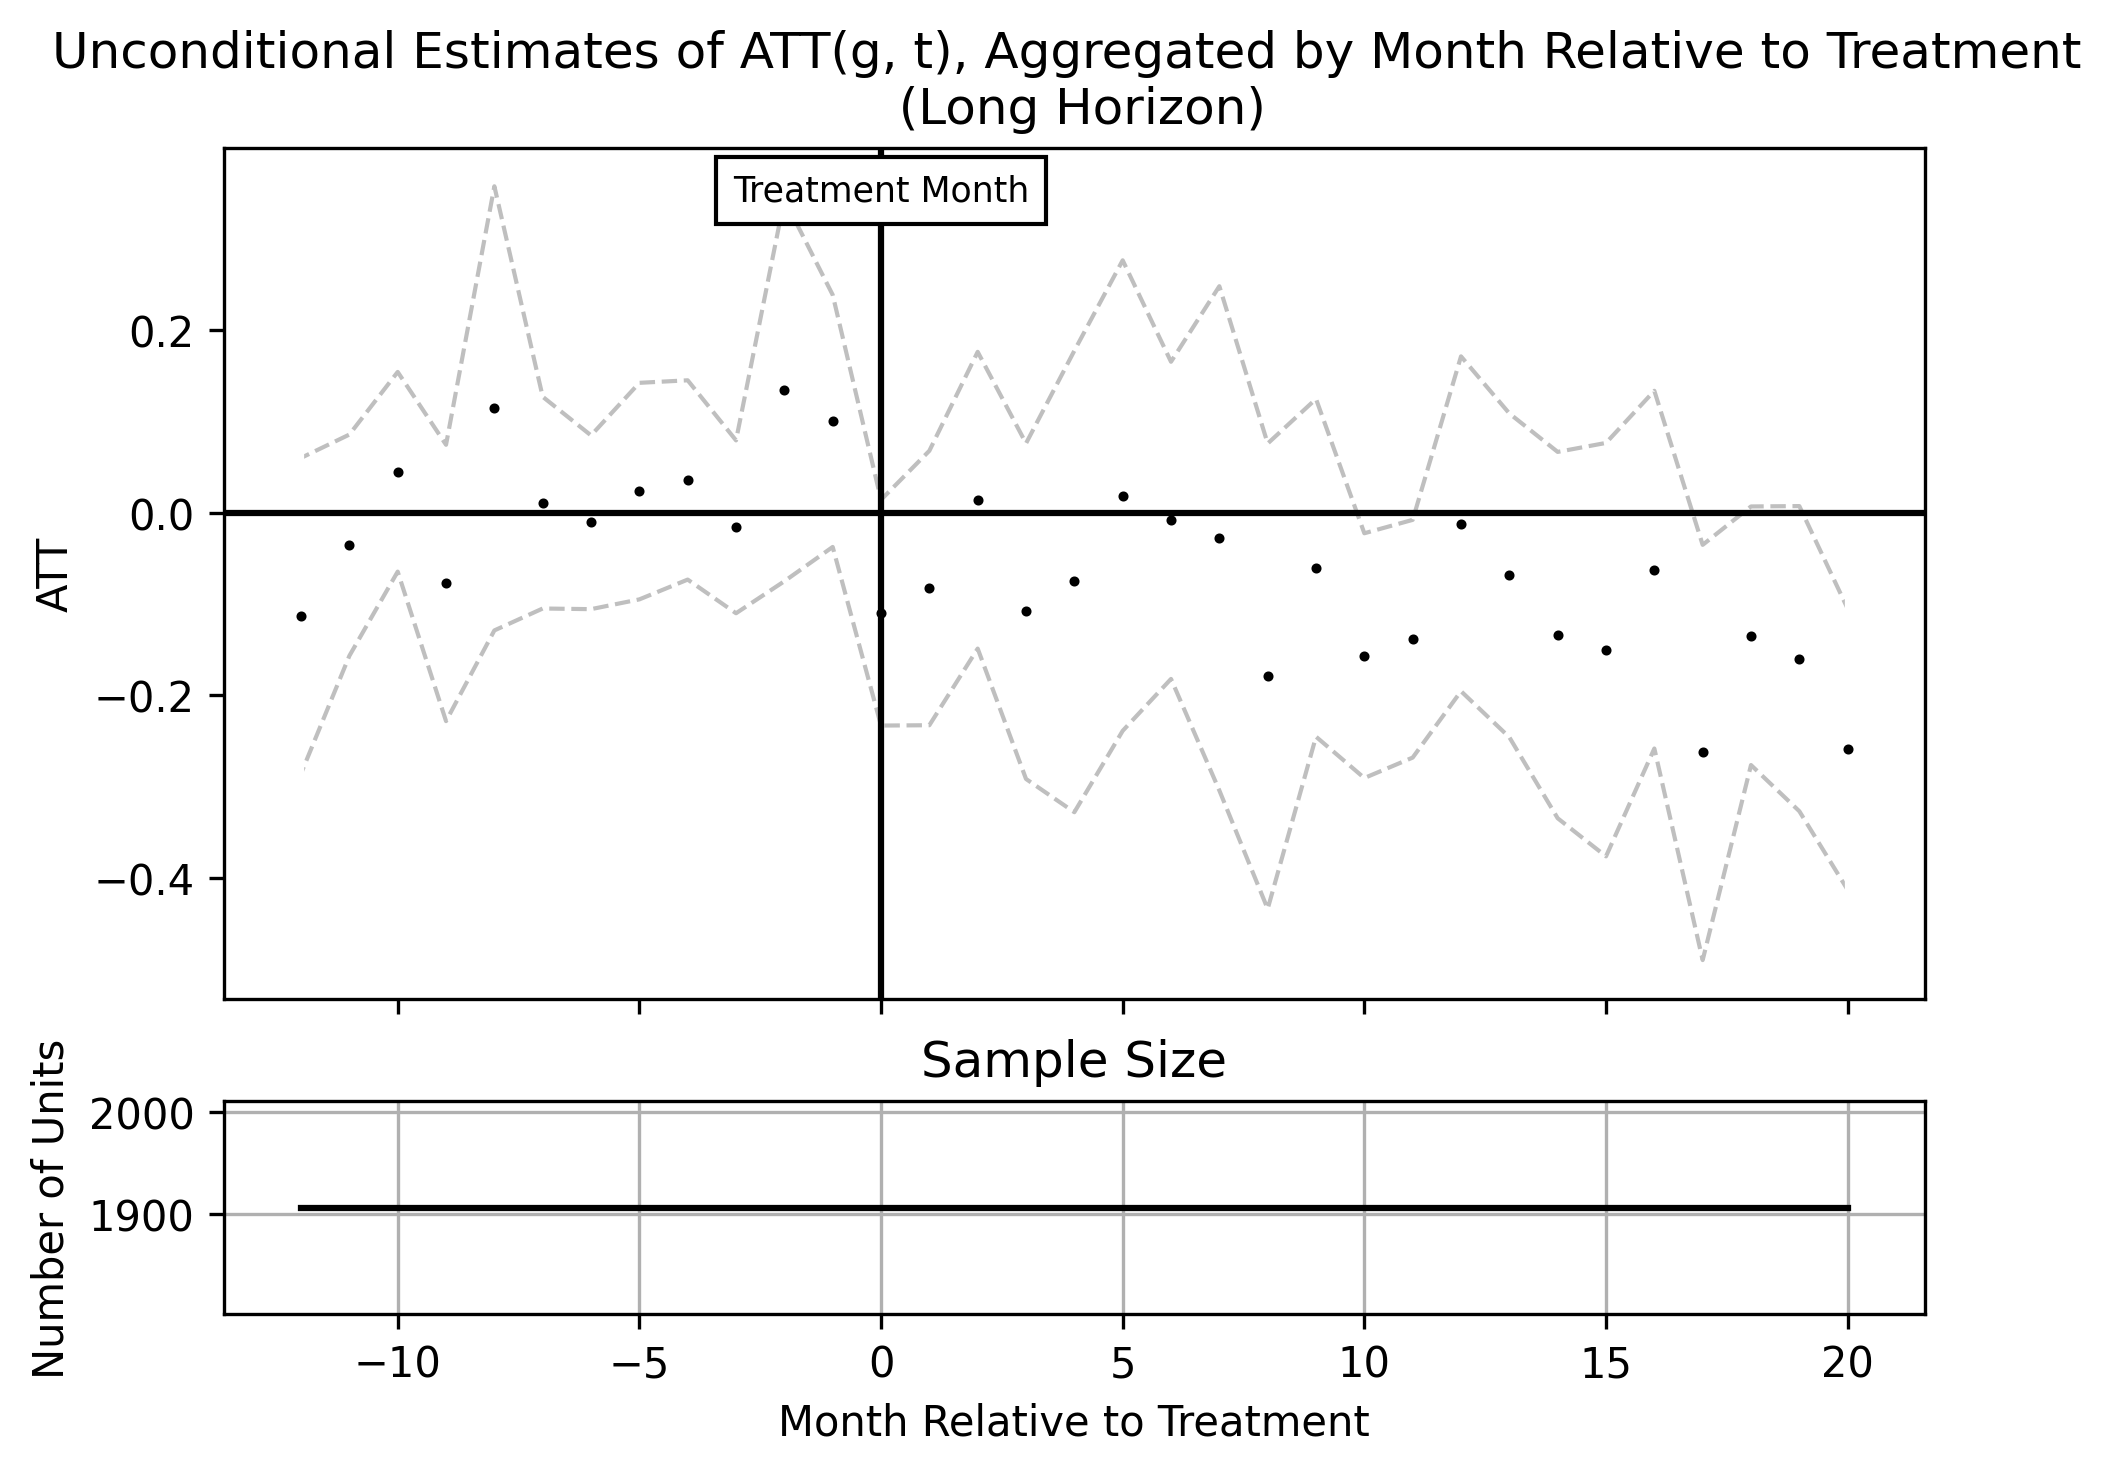

In [15]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=20,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

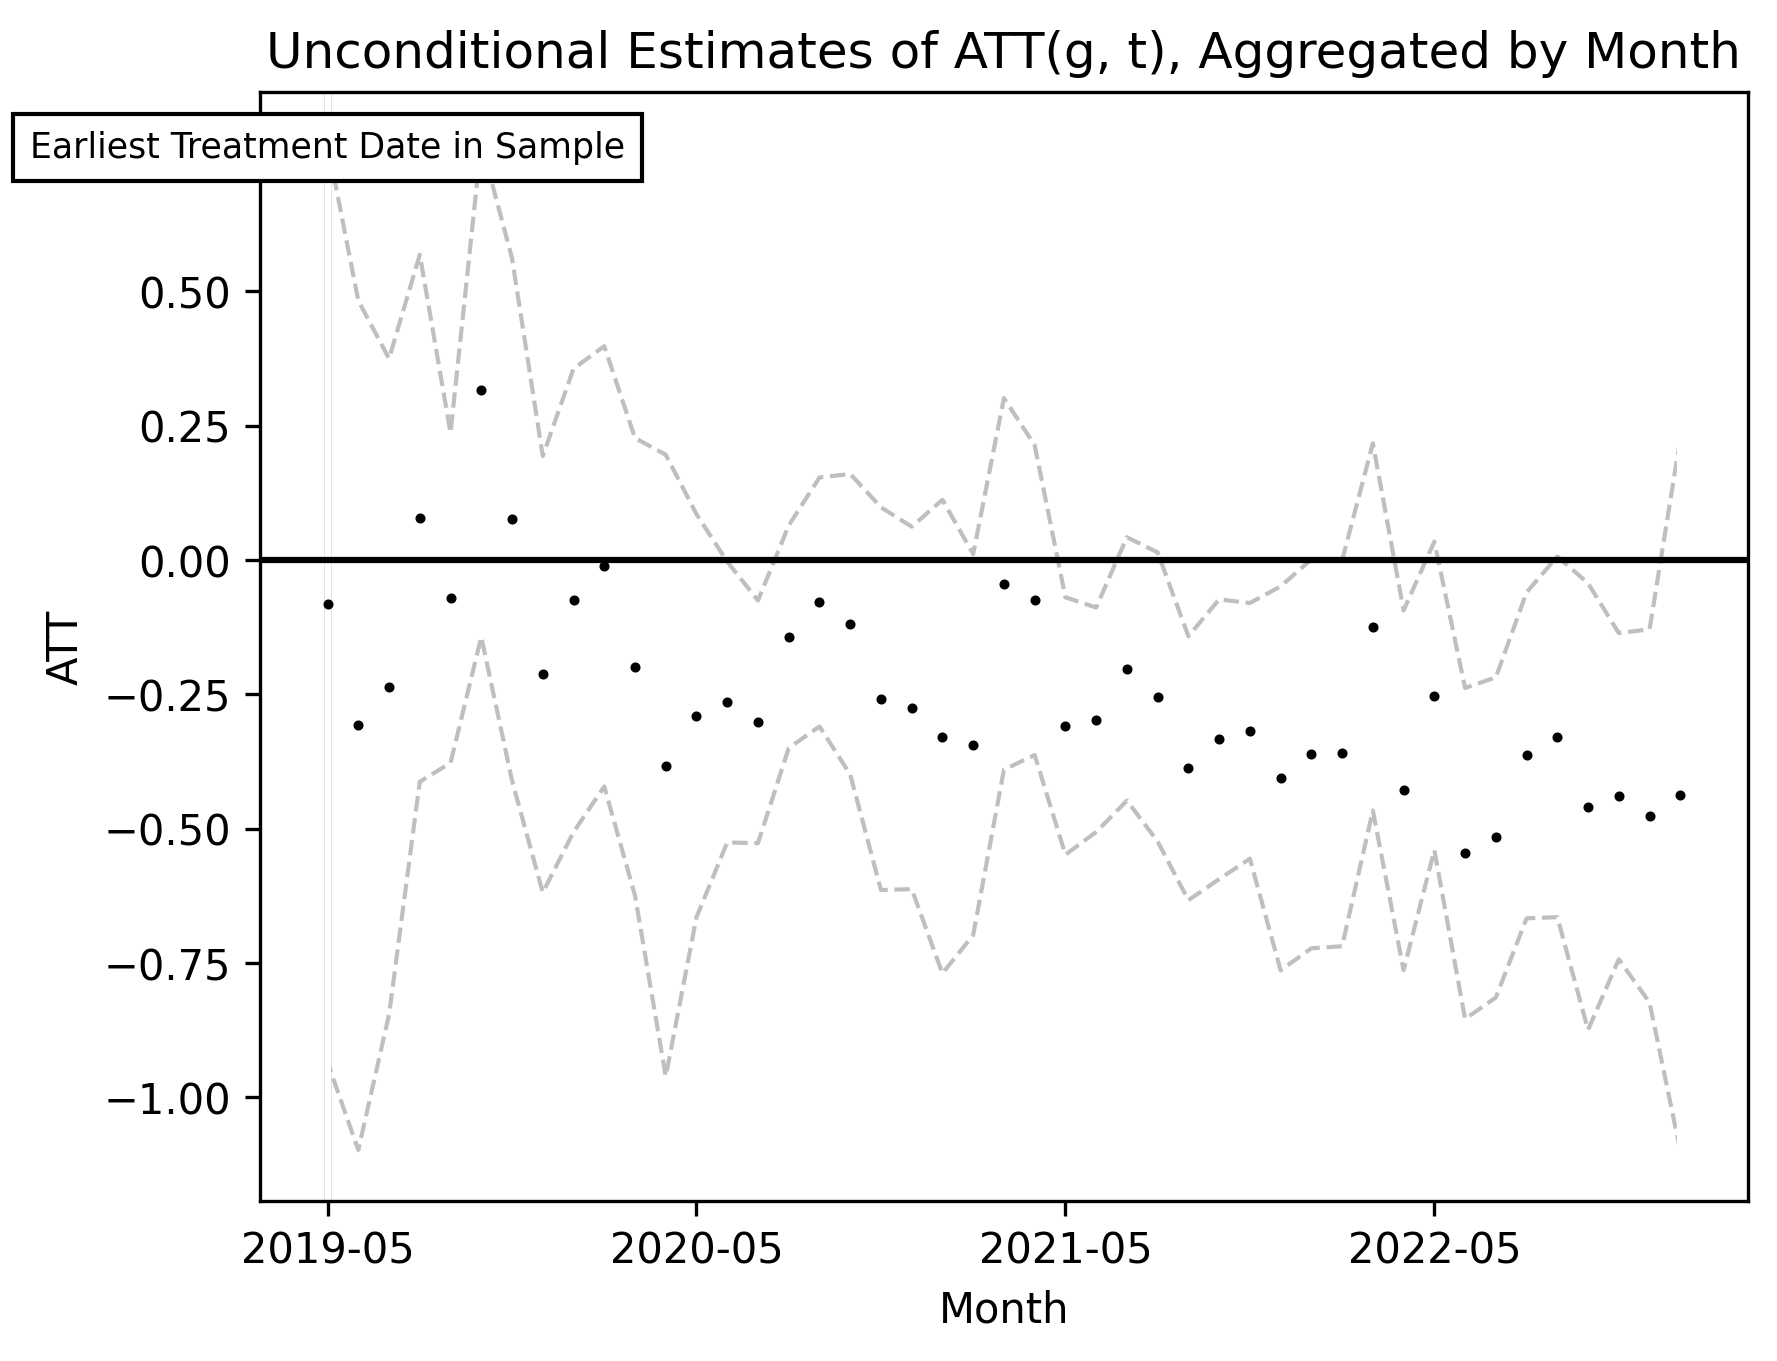

In [9]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

In [11]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
formula = 'crimes ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]   49%|█████████▊          | 1066/2184 [00:16<00:12, 92.42it/s] /Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
Computing ATTgt [workers=10]   50%|█████████▉          | 1082/2184 [00:16<00:11, 93.29it/s]/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/pyth

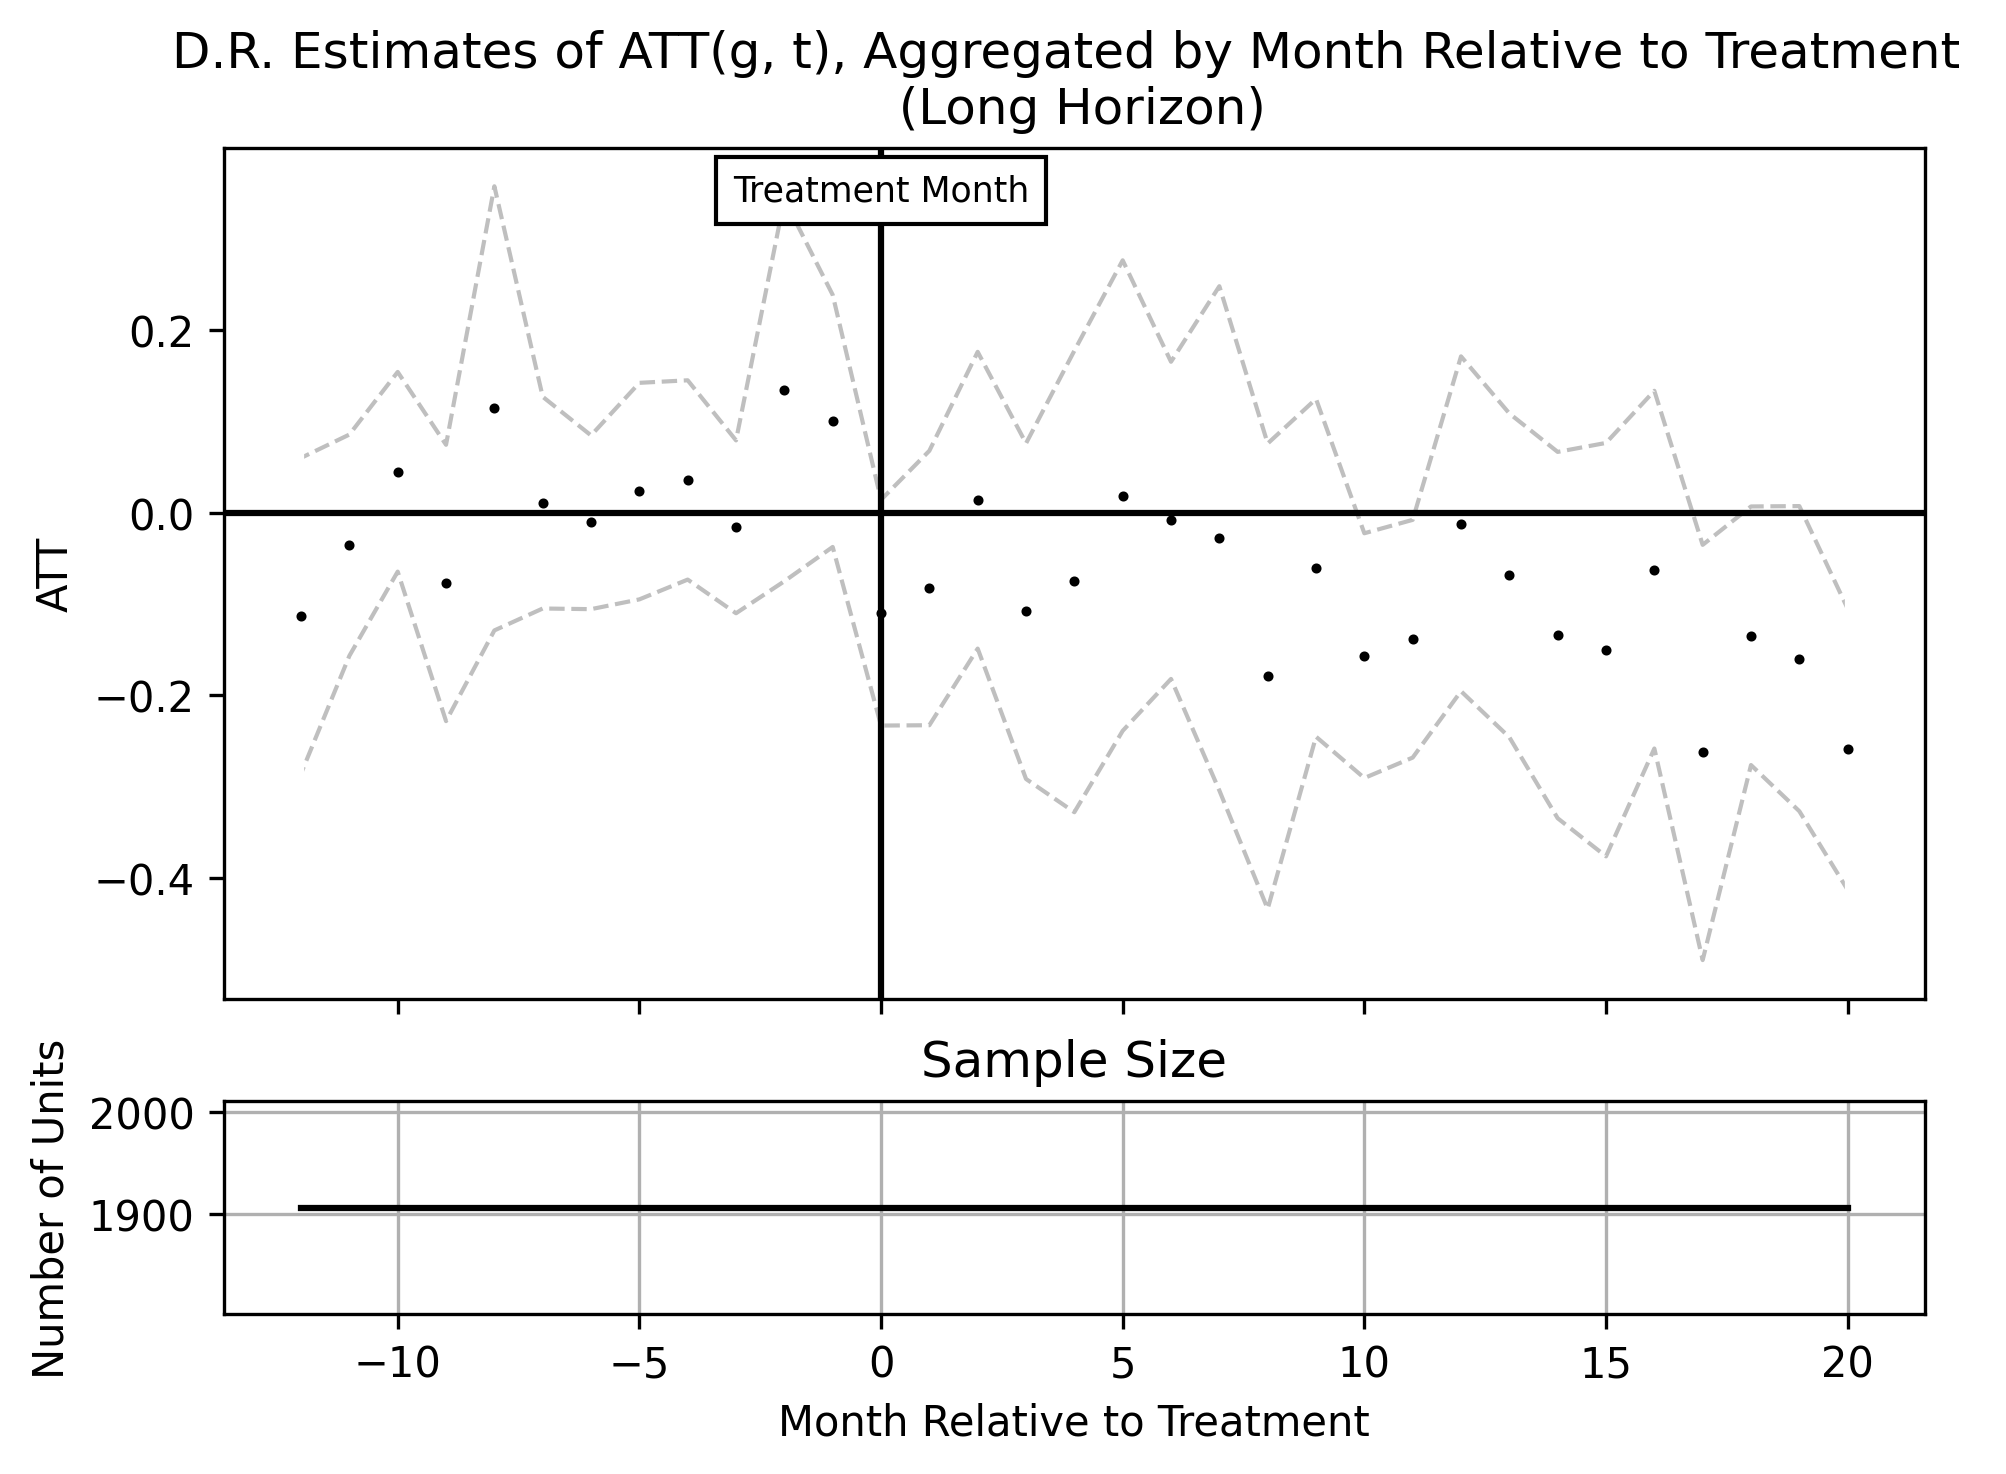

In [16]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=20,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

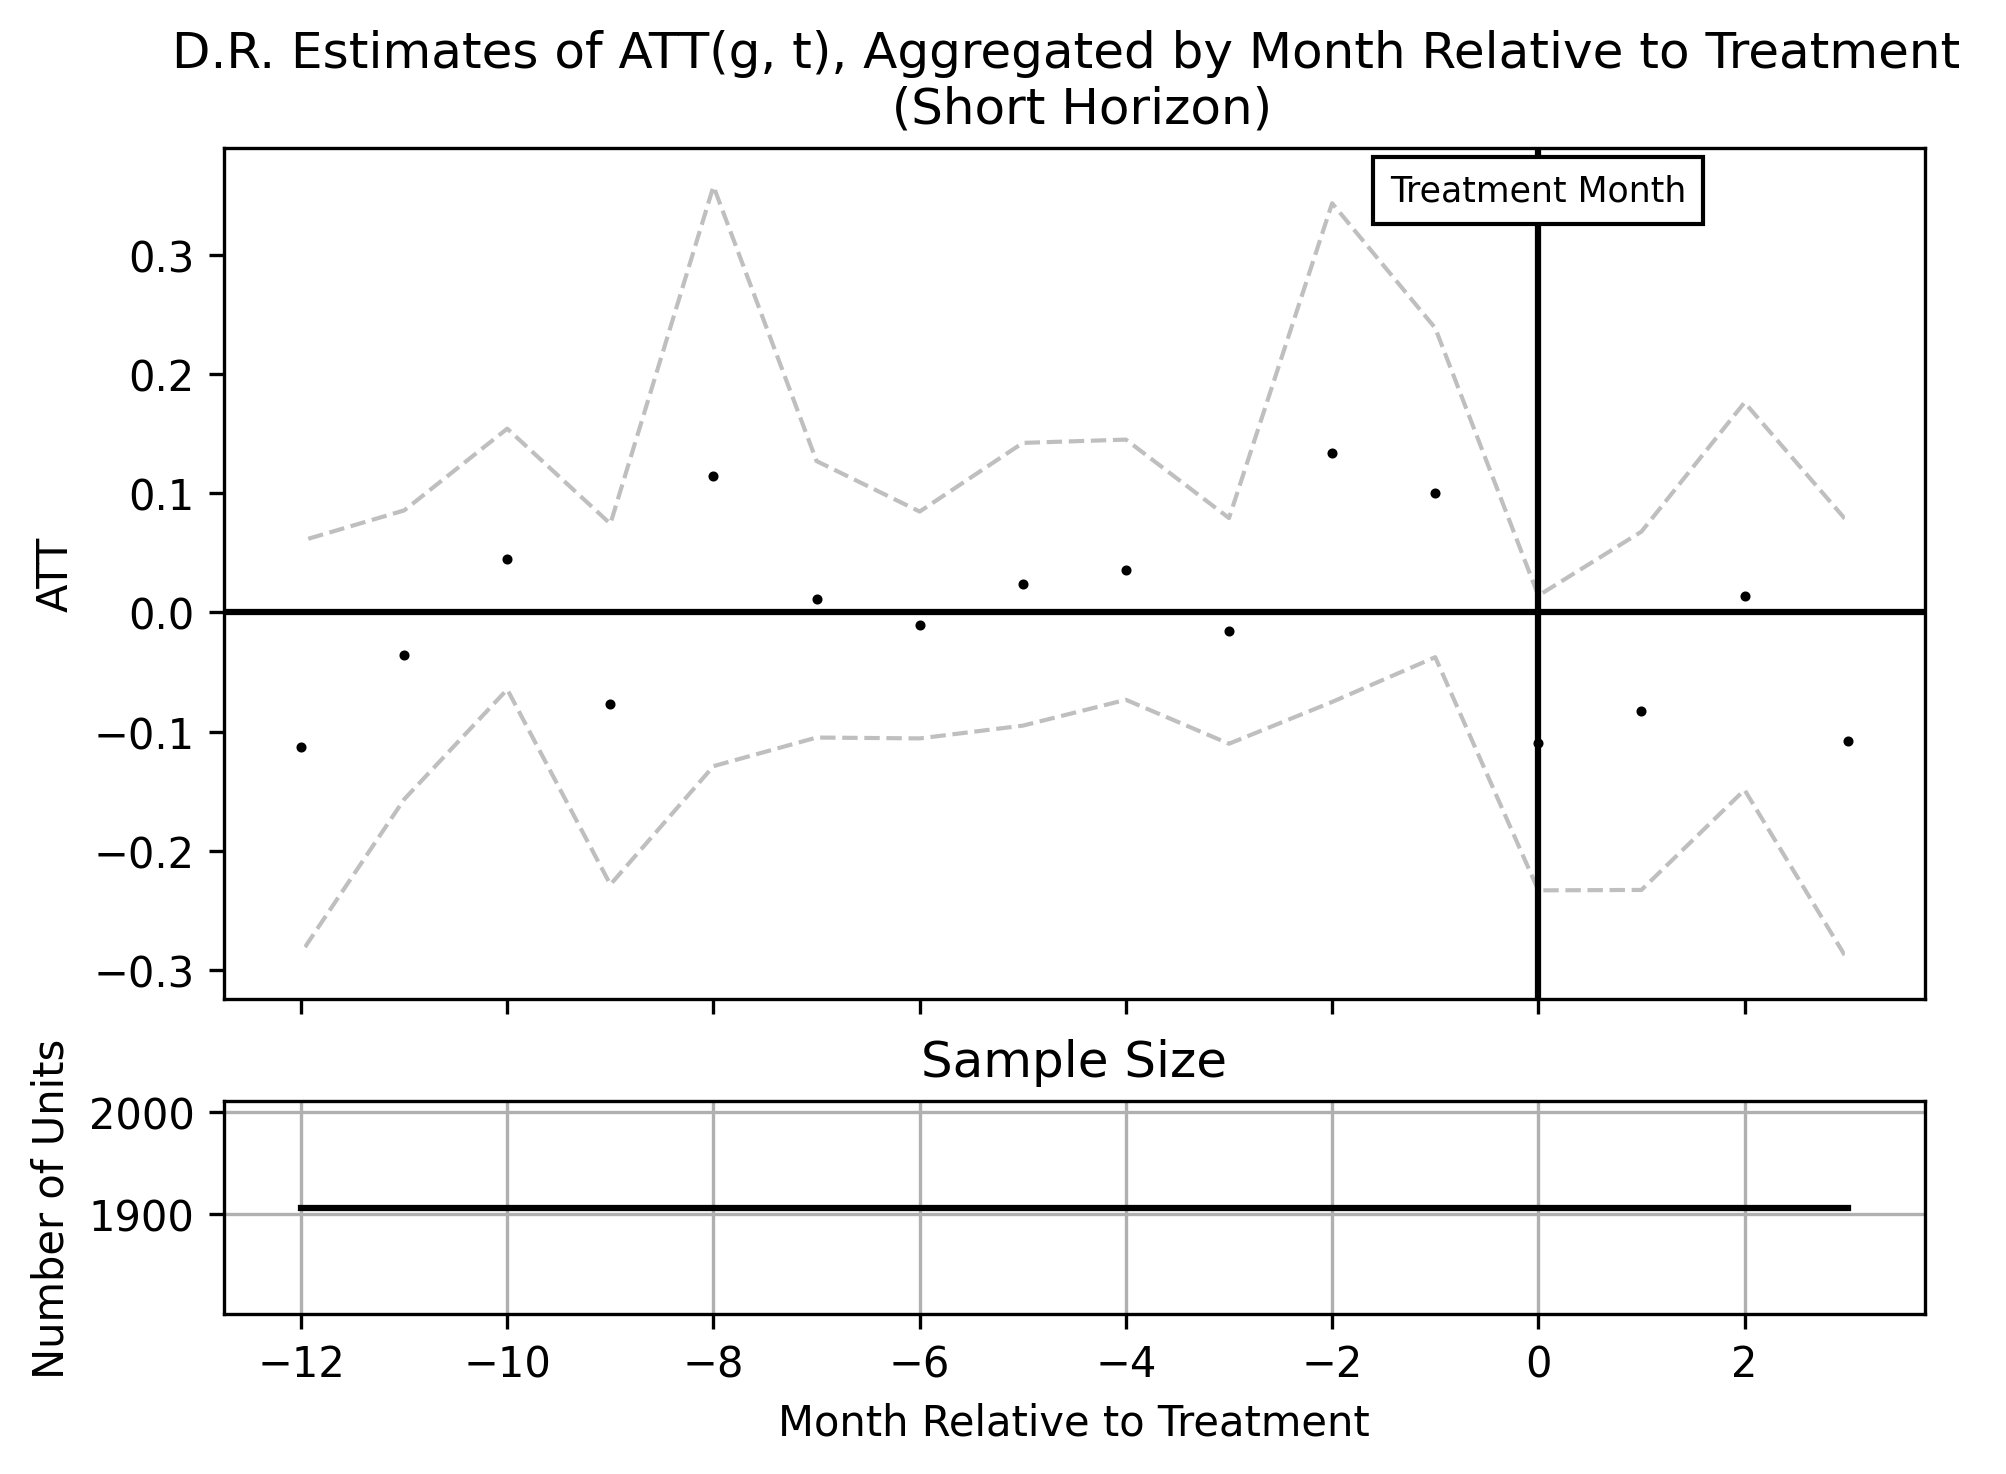

In [13]:
# Plot D.R. ATT(t-g)s on a short horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_short_horizon.png", start_period=-12,
                                 end_period=3,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Short Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

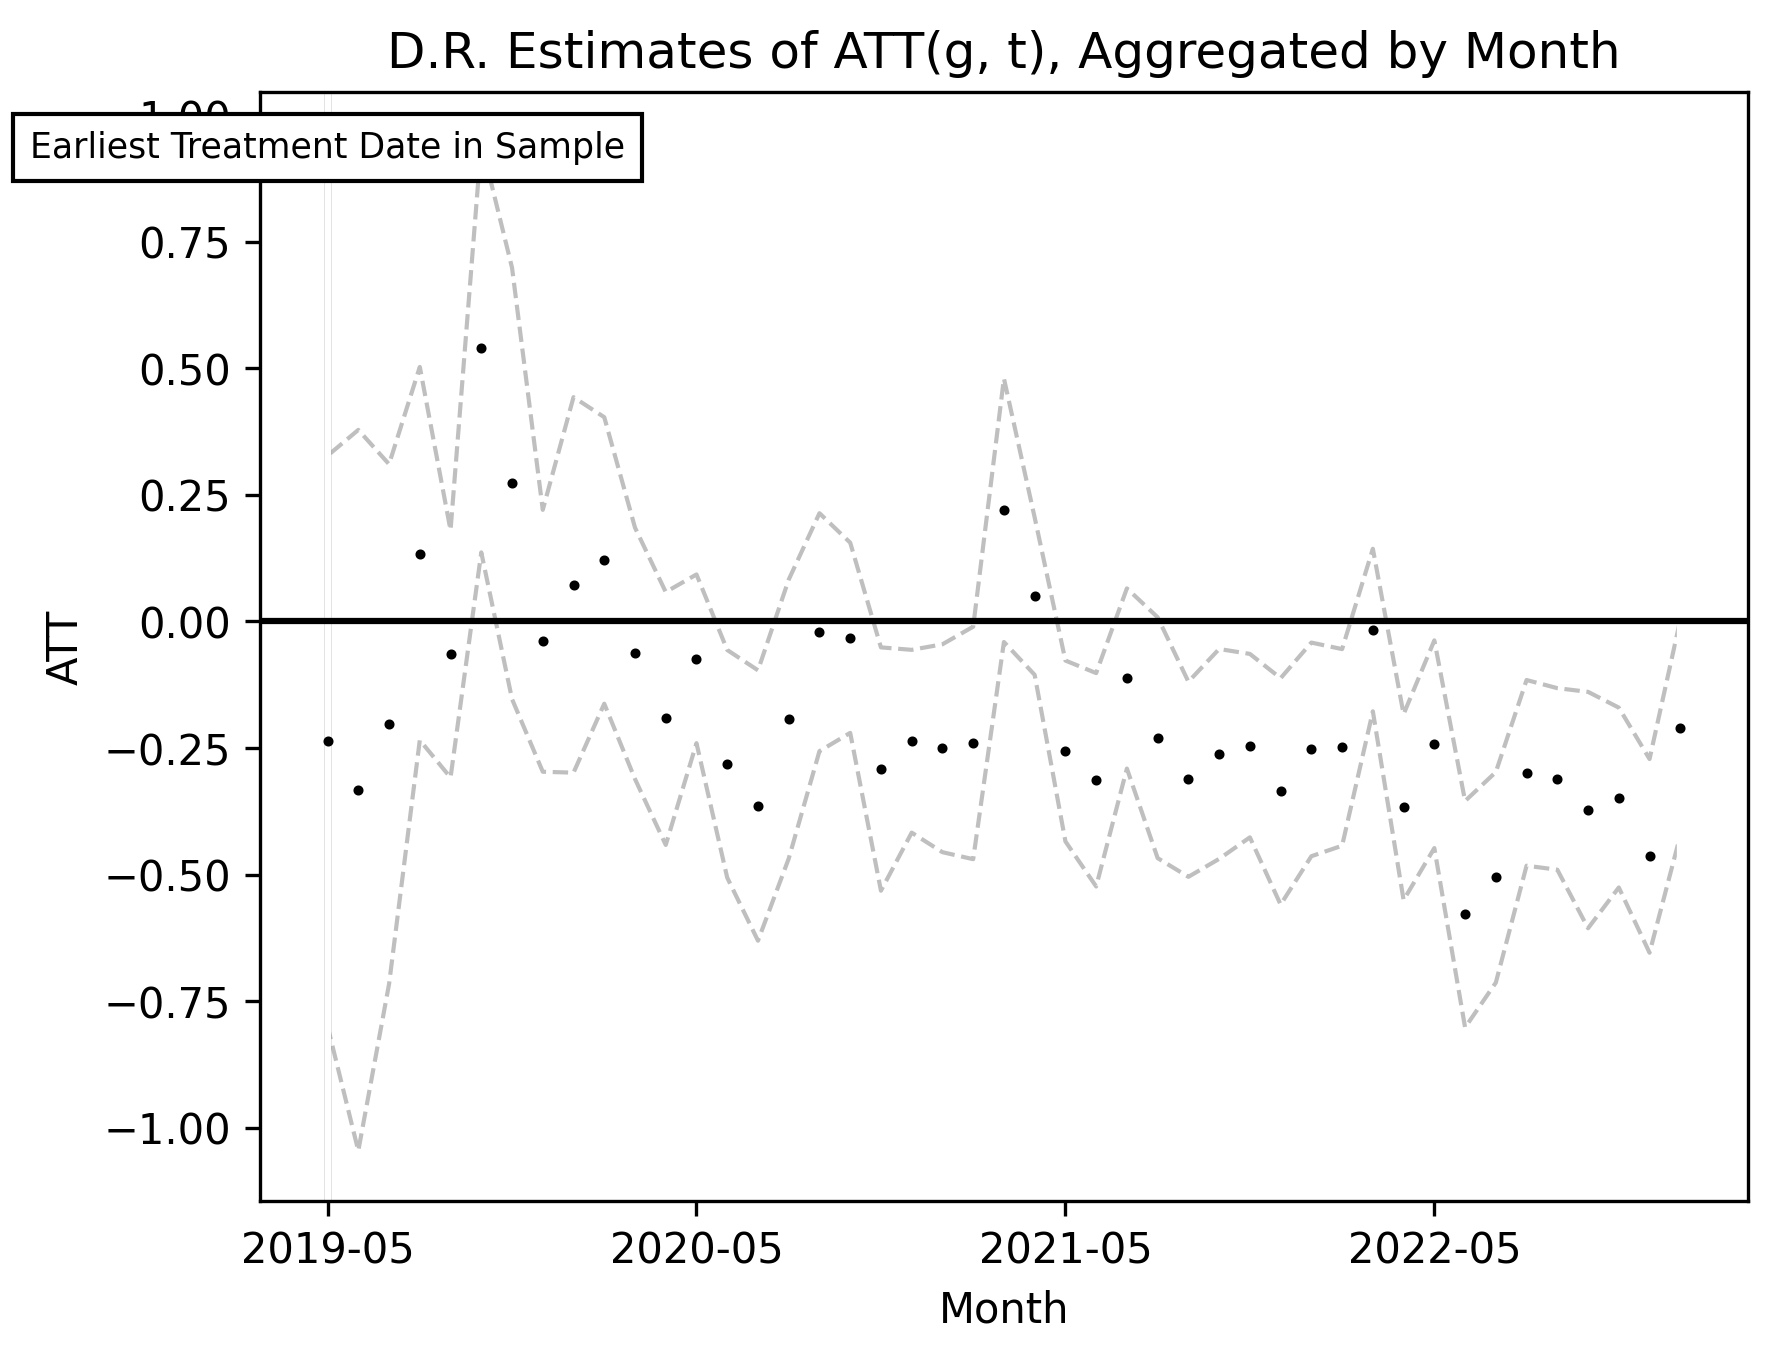

In [14]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")